# DACON 월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
대회 링크 : [월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
](https://dacon.io/competitions/official/235713/overview/description)

## Column 설명 / Target에 대한 구상

### FEATURES

index  

gender: 성별  

car: 차량 소유 여부  

reality: 부동산 소유 여부  

child_num: 자녀 수  

income_total: 연간 소득  

income_type: 소득 분류 :  
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  
[세일즈(영업), 일반 직장, 공무원, 연금수령자, 학생]  
여기서 세일즈가 다른 이유 -> 월급 + 자신이 파는 것까지 버는 특이한 직업임

edu_type: 교육 수준  :  
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  
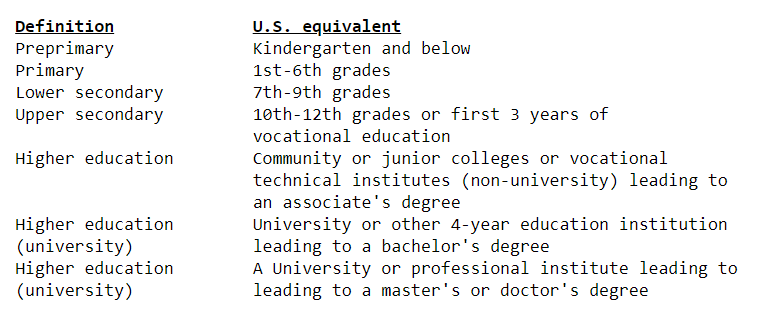  


family_type: 결혼 여부 :  
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

house_type: 생활 방식 :  
['Municipal apartment', 'House / apartment', 'With parents',  
'Co-op apartment', 'Rented apartment', 'Office apartment']

DAYS_BIRTH: 출생일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

DAYS_EMPLOYED: 업무 시작일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

양수 값은 고용되지 않은 상태를 의미함

FLAG_MOBIL: 핸드폰 소유 여부

work_phone: 업무용 전화 소유 여부

phone: 전화 소유 여부

email: 이메일 소유 여부

occyp_type : 직업 유형 -> 구분을 지을 수 있을까? ex) 연봉별  
										
family_size: 가족 규모

begin_month: 신용카드 발급 월  
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

---
### TARGET

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

---
### Target은 0, 1, 2 -> 분류 모델이 필요함 (Classification)

[CatBoost doc](https://catboost.ai/)

## CatBoost Version

## 0. Import & Reading data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss

# RandomForest, Catboost & Optuna
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
import random

import warnings
warnings.filterwarnings(action='ignore')

In [56]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [57]:
print(train.shape)

(26457, 20)


In [58]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [59]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


## 1. Basic EDA

칼럼을 보며
- `gender, car, reality` -> binary
- `income_total, DAYS~` -> num, cont.
- `family_size, child_num` -> 연관되어 있을 가능성이 높음
- `income_type, edu_type, family_type, house_type` -> cat. / str

In [60]:
sns.set_palette(sns.color_palette('Purples'))

Text(0.5, 1.0, 'Possesion of Real estate-Credit score countplot')

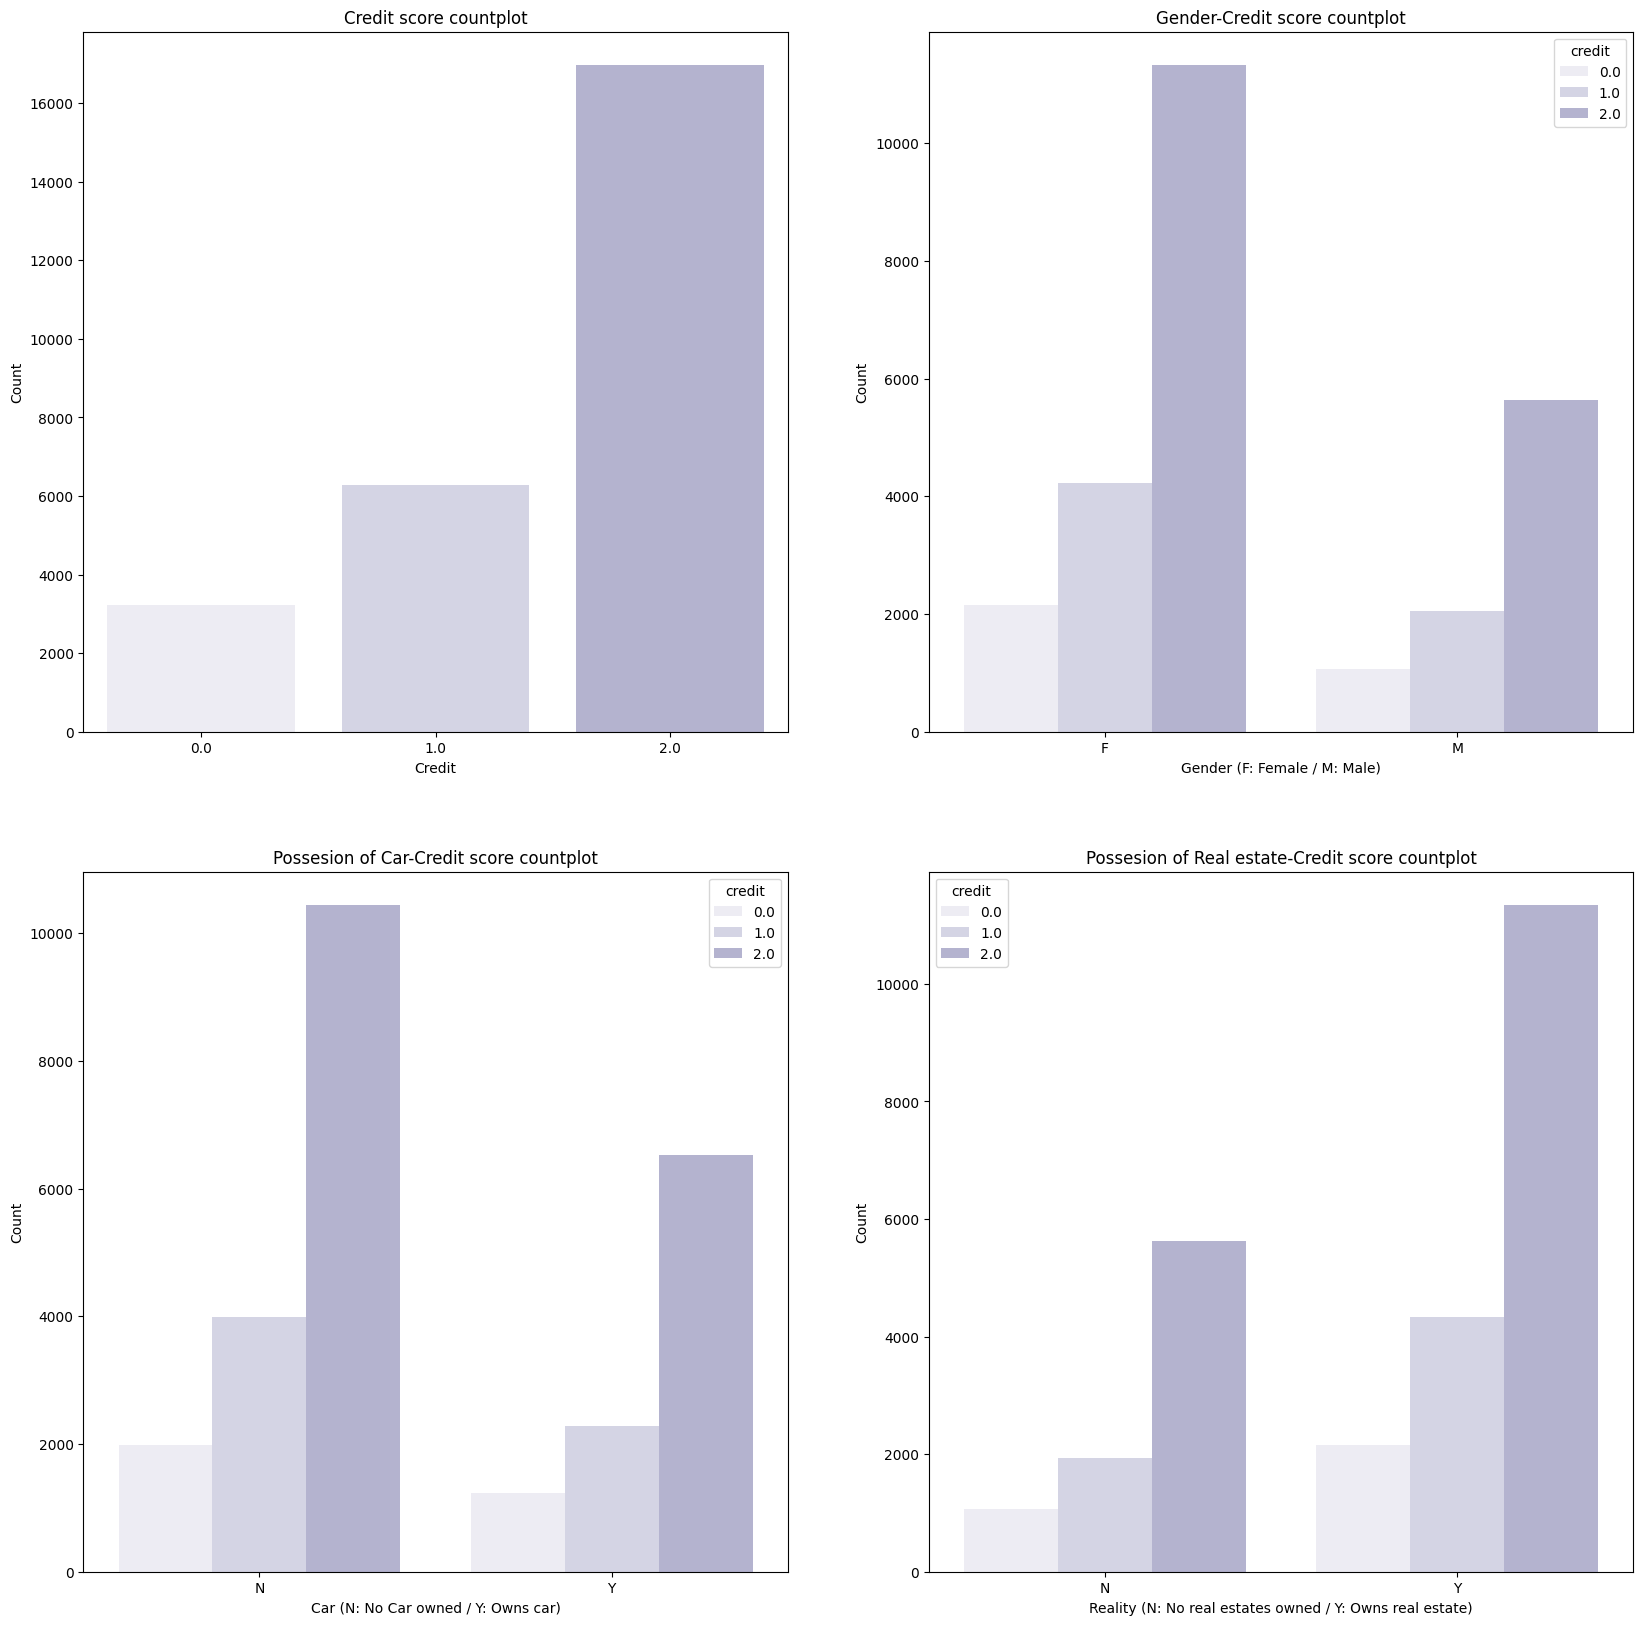

In [61]:
fig1, ax1 = plt.subplots(2, 2, figsize=(20, 20))

credit_count = sns.countplot(train, x='credit', ax=ax1[0,0])
credit_count.set_ylabel('Count')
credit_count.set_xlabel('Credit')
credit_count.set_title('Credit score countplot')

gender_count = sns.countplot(train, x='gender', hue='credit', ax=ax1[0,1])
gender_count.set_ylabel('Count')
gender_count.set_xlabel('Gender (F: Female / M: Male)')
gender_count.set_title('Gender-Credit score countplot')

car_count = sns.countplot(train, x='car', hue='credit', ax=ax1[1,0])
car_count.set_ylabel('Count')
car_count.set_xlabel('Car (N: No Car owned / Y: Owns car)')
car_count.set_title('Possesion of Car-Credit score countplot')

reality_count = sns.countplot(train, x='reality', hue='credit', ax=ax1[1,1])
reality_count.set_ylabel('Count')
reality_count.set_xlabel('Reality (N: No real estates owned / Y: Owns real estate)')
reality_count.set_title('Possesion of Real estate-Credit score countplot')

In [62]:
# communication 변수 생성
train['communication'] = 0

for col in ['phone','work_phone','email'] :
    train['communication'] += train[col]
    train = train.drop(col, axis=1)

train['communication'].unique()

array([0, 1, 3, 2], dtype=int64)

In [63]:
# test에도 communication 변수 생성
test['communication'] = 0

for col in ['phone','work_phone','email'] :
    test['communication'] += test[col]
    test = test.drop(col, axis=1)

Text(0.5, 1.0, 'Number of comm. methods-Credit score countplot')

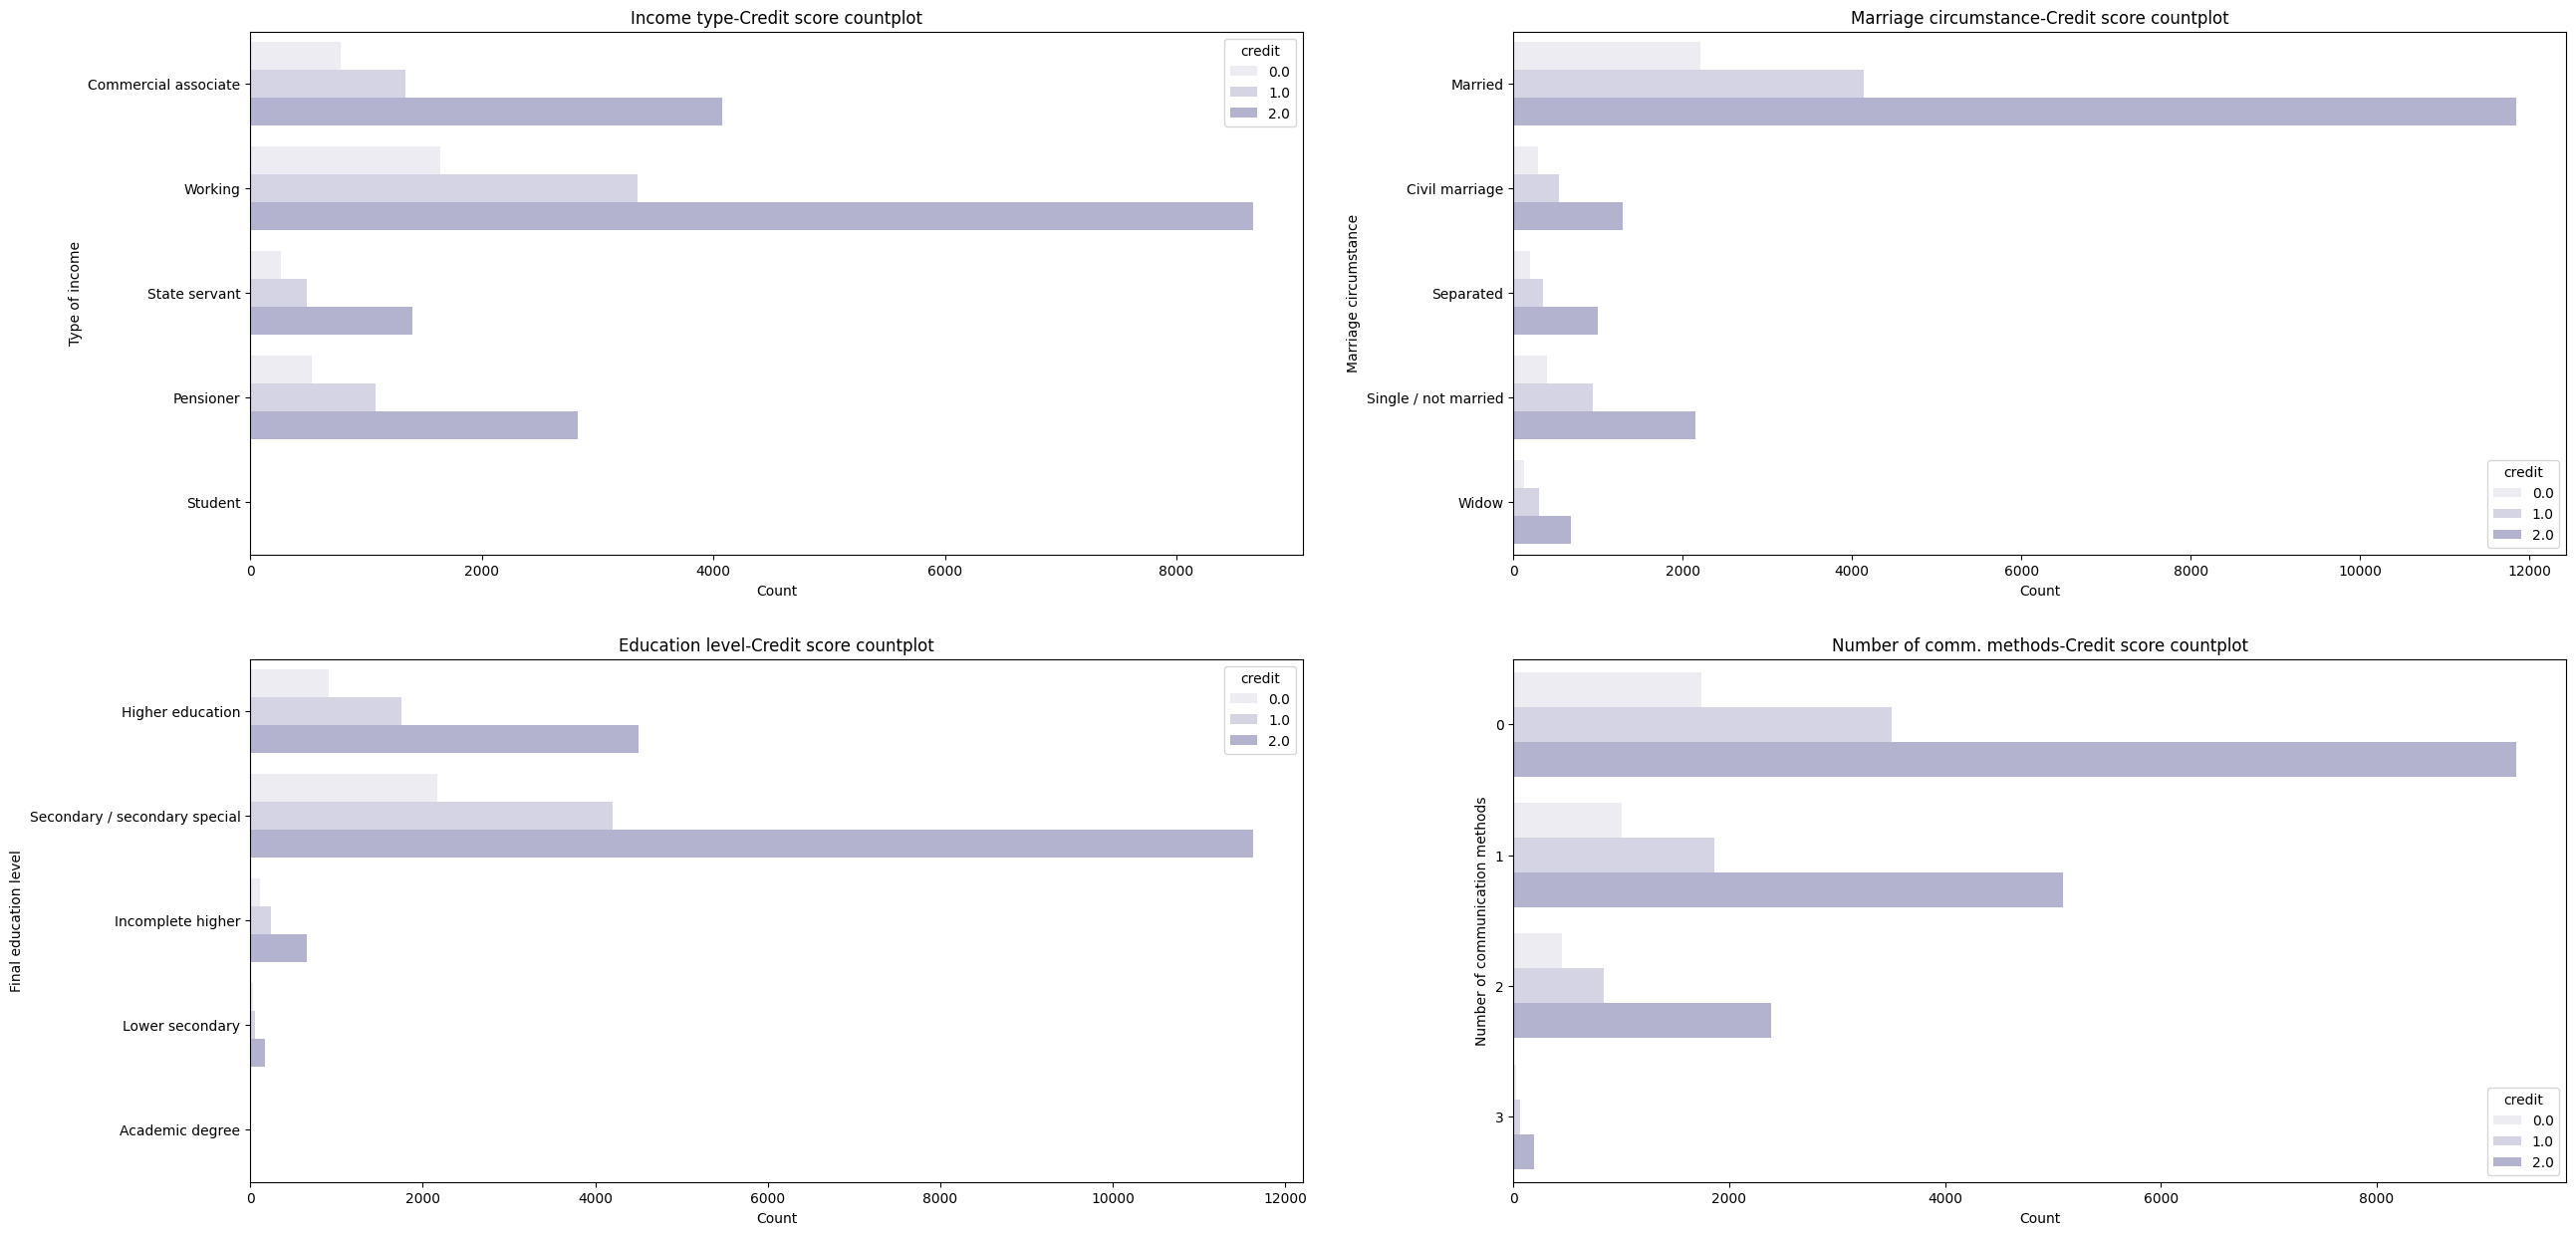

In [64]:
fig2, ax2 = plt.subplots(2, 2, figsize=(30, 15))

income_count = sns.countplot(train, y='income_type', hue='credit', ax=ax2[0,0])
income_count.set_ylabel('Type of income')
income_count.set_xlabel('Count')
income_count.set_title('Income type-Credit score countplot')

family_count = sns.countplot(train, y='family_type', hue='credit', ax=ax2[0,1])
family_count.set_ylabel('Marriage circumstance')
family_count.set_xlabel('Count')
family_count.set_title('Marriage circumstance-Credit score countplot')

edu_count = sns.countplot(train, y='edu_type', hue='credit', ax=ax2[1,0])
edu_count.set_ylabel('Final education level')
edu_count.set_xlabel('Count')
edu_count.set_title('Education level-Credit score countplot')

comm_count = sns.countplot(train, y='communication', hue='credit', ax=ax2[1,1])
comm_count.set_ylabel('Number of communication methods')
comm_count.set_xlabel('Count')
comm_count.set_title('Number of comm. methods-Credit score countplot')


<AxesSubplot: xlabel='child_num', ylabel='count'>

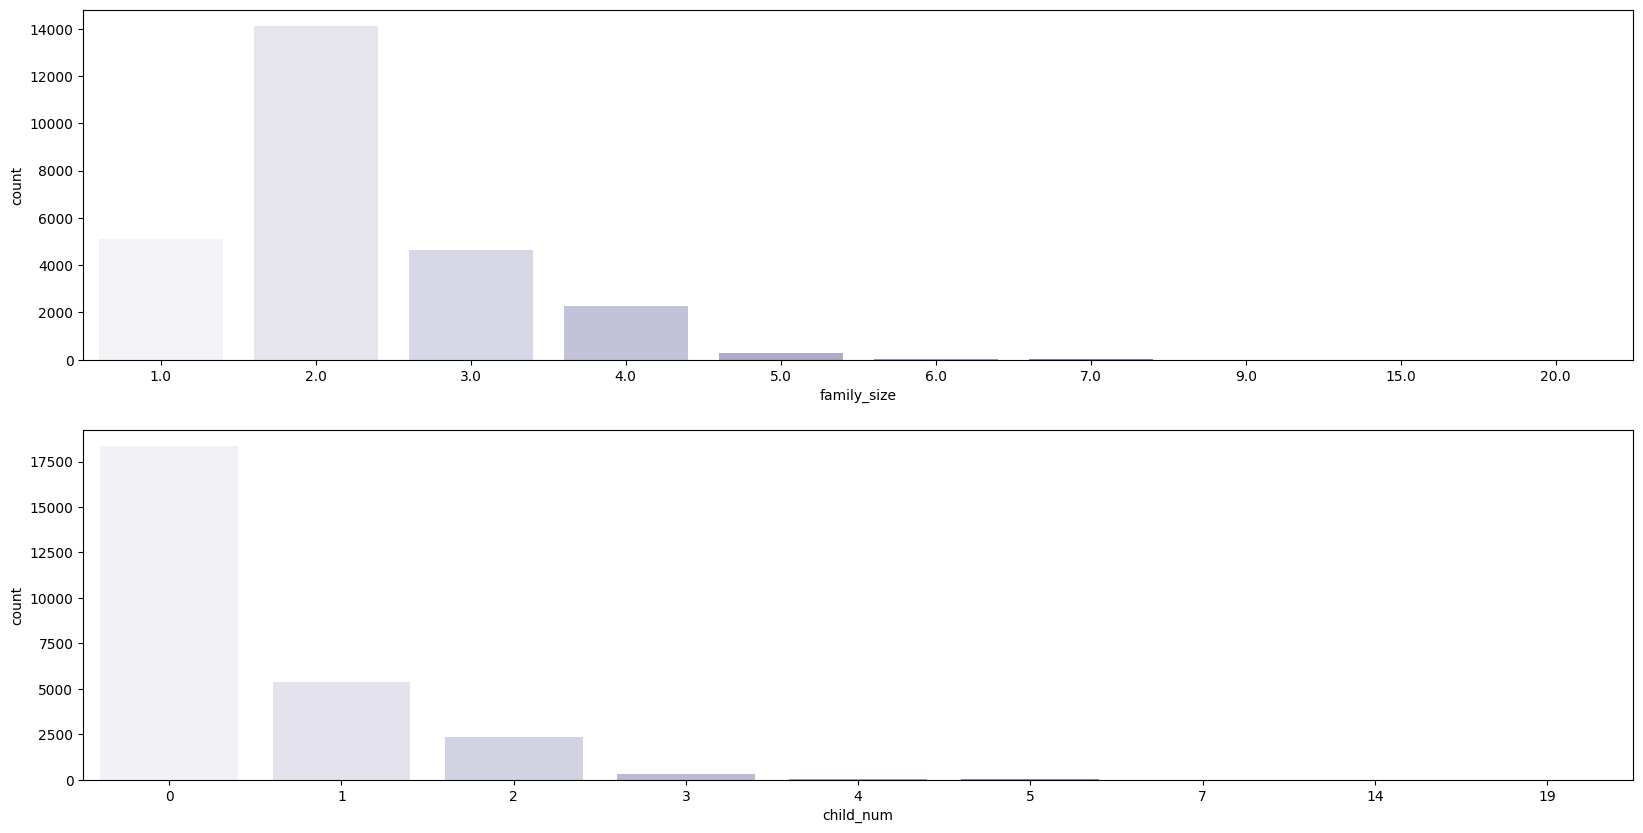

In [65]:
fig3, ax3 = plt.subplots(2, 1, figsize=(20, 10))

sns.countplot(train, x='family_size', ax=ax3[0], palette='Purples') # family_size가 5 이상이면 이상치
sns.countplot(train, x='child_num', ax=ax3[1], palette='Purples') # child_num이 3 이상이면 이상치

<AxesSubplot: title={'center': 'Income Total Histogram'}, xlabel='Income', ylabel='Count'>

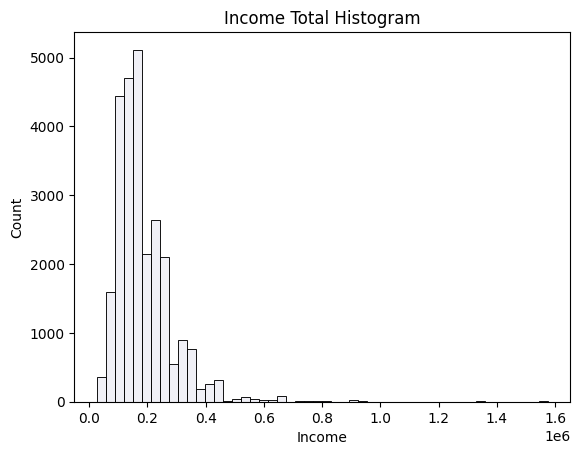

In [66]:
# income_total
plt.title("Income Total Histogram")
plt.xlabel('Income')
plt.ylabel('Count')
sns.histplot(train, x='income_total', bins=50) # right-skewed

Text(0.5, 1.0, 'Correlation plot')

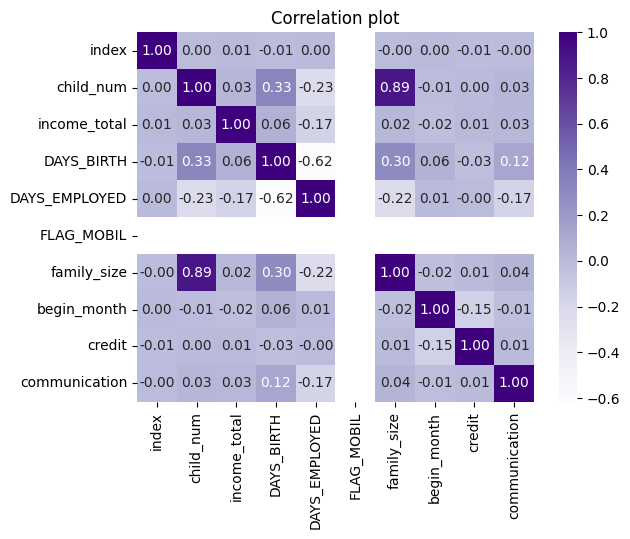

In [67]:
# 전반적인 corrplot
corr = train.corr()
sns.heatmap(corr, cmap='Purples', annot=True, fmt='.2f')
plt.title('Correlation plot')

## 3. Preprocesssing

~~index~~

### Before going in
A note from CatBoost doc:

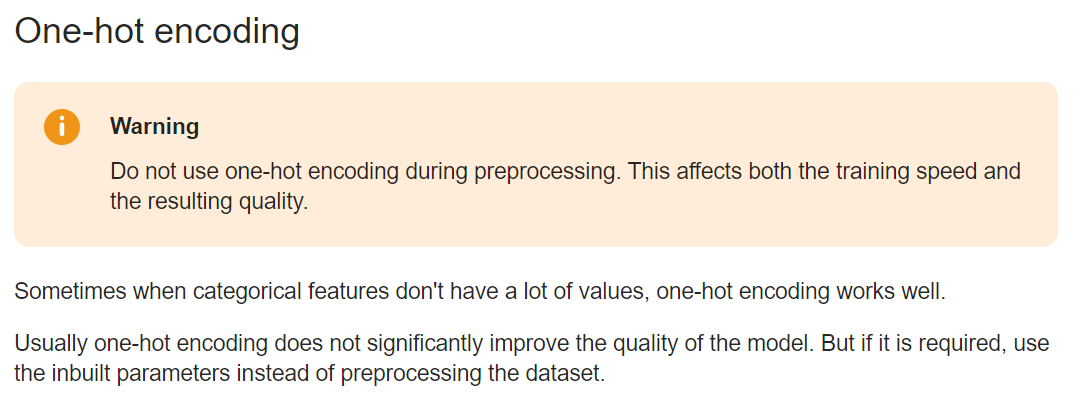

---

### Binary 변수 : 

gender: 성별  
car: 차량 소유 여부  
reality: 부동산 소유 여부  
#### -> CatBoost에서 범주형으로 처리하도록 함 (원래는 one-hot encoding을 진행하려했으나 위의 제약으로 인해 배제)

---

### 소득, 직업 관련 변수  

income_total: 연간 소득 

#### -> log transformation 필요 (right-skewed)


income_type: 소득 분류 :  
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']  
[세일즈(영업), 일반 직장, 공무원, 연금수령자, 학생]  
여기서 세일즈가 다른 이유 -> 월급 + 자신이 파는 것까지 버는 특이한 직업임

edu_type: 교육 수준  :  
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']  
family_type: 결혼 여부 :  
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

house_type: 생활 방식 :  
['Municipal apartment', 'House / apartment', 'With parents',  
'Co-op apartment', 'Rented apartment', 'Office apartment']

occyp_type : 직업 유형
#### -> 전부 Catboost 모델에서 범주형으로 처리토록 함

---

### 날짜 관련 변수

DAYS_EMPLOYED: 업무 시작일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미  
양수 값은 고용되지 않은 상태를 의미함
#### -> 근무기간을 년 단위로 파생변수 생성

DAYS_BIRTH: 출생일 : 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
#### -> 나이로 파생변수 생성

begin_month: 신용카드 발급 월  
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미  


~~FLAG_MOBIL: 핸드폰 소유 여부~~

---

### 통신 관련 Binary 변수 : communication으로 통합 (위에서 이미 진행)

work_phone: 업무용 전화 소유 여부  
phone: 전화 소유 여부  
email: 이메일 소유 여부

---

### 가정 관련 변수
family_size: 가족 규모
child_num: 자녀 수  
#### -> 파생변수 생성? PCA?

---

In [68]:
# 불필요 변수 제거
train.drop(['index','FLAG_MOBIL'], inplace=True, axis=1)
test.drop(['index','FLAG_MOBIL'], inplace=True, axis=1)

In [69]:
# income_total 로그 변환
train['income_total'] = np.log(train['income_total'])
test['income_total'] = np.log(test['income_total'])

<AxesSubplot: xlabel='income_total', ylabel='Count'>

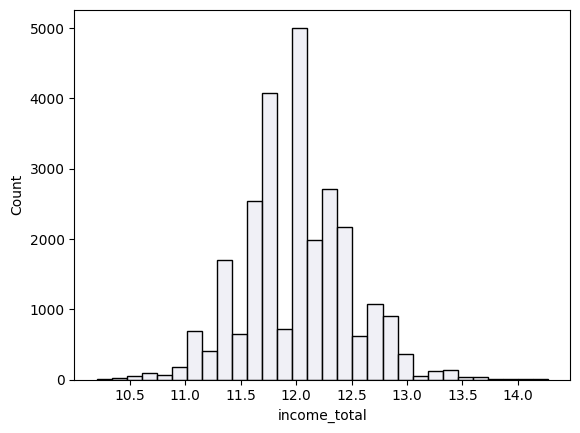

In [70]:
# income_total 확인
sns.histplot(train, x='income_total', bins=30, palette='Purples') # 나름대로 균일한 분포를 이룸

In [71]:
# DAYS_EMPLOYED - 0 이상은 전부 무직이므로 0으로 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [72]:
# DAYS_BIRTH, DAYS_EMPLOYED, begin_month 모두 현시점으로 역행이 아니라
# 해당 시점에서 현재까지의 시간을 나타내기 위해 양수로 처리

# DAYS_BIRTH 모두 양수로 변환
train['DAYS_BIRTH'] = np.abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = np.abs(test['DAYS_BIRTH'])

# DAYS_EMPLOYED 모두 양수로 변환
train['DAYS_EMPLOYED'] = np.abs(train['DAYS_EMPLOYED'])
test['DAYS_EMPLOYED'] = np.abs(test['DAYS_EMPLOYED'])

# begin_month 모두 양수로 변환
train['begin_month'] = np.abs(train['begin_month'])
test['begin_month'] = np.abs(test['begin_month'])

In [73]:
# 현시점 나이를 age_y 변수 설정
train['age_y'] = train['DAYS_BIRTH'] // 365
test['age_y'] = test['DAYS_BIRTH'] // 365

In [74]:
# 근무 기간 (년) working_y 변수로 설정
train['working_y'] = train['DAYS_EMPLOYED'] // 365
test['working_y'] = test['DAYS_EMPLOYED'] // 365

In [75]:
# 결측치 확인
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
occyp_type       8171
family_size         0
begin_month         0
credit              0
communication       0
age_y               0
working_y           0
dtype: int64

In [76]:
test.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
occyp_type       3152
family_size         0
begin_month         0
communication       0
age_y               0
working_y           0
dtype: int64

In [77]:
# 결측치 NaN으로 처리
train.fillna("NaN",inplace=True)
test.fillna("NaN",inplace=True)

In [78]:
# DAYS_EMPLOYED가 0이고 occyp_type이 None이면 무직자
# DAYS_EMPLOYED가 0이 아니고 occyp_type이 None이면 결측치
train.loc[((train['DAYS_EMPLOYED']== 0) & (train['occyp_type'] == "NaN")),'occyp_type'] = 'No_Job'
test.loc[((test['DAYS_EMPLOYED']== 0) & (test['occyp_type'] == "NaN")),'occyp_type'] = 'No_Job'

In [79]:
train.loc[train['occyp_type']=='NaN']

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,communication,age_y,working_y
0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,NaN,2.0,6.0,1.0,0,38,12
8,M,Y,Y,1,12.100712,Commercial associate,Higher education,Married,House / apartment,15131,1466,NaN,3.0,38.0,2.0,1,41,4
19,F,N,Y,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,13727,6031,NaN,2.0,7.0,2.0,0,37,16
20,M,N,N,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,19850,1753,NaN,2.0,35.0,2.0,1,54,4
23,M,Y,N,0,12.323856,Working,Secondary / secondary special,Married,Municipal apartment,14542,444,NaN,2.0,18.0,2.0,3,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26433,F,Y,N,0,11.707670,State servant,Higher education,Married,House / apartment,19912,4973,NaN,2.0,31.0,2.0,1,54,13
26435,F,N,N,1,11.744037,Working,Secondary / secondary special,Widow,House / apartment,19691,473,NaN,2.0,40.0,2.0,0,53,1
26437,M,N,Y,0,12.100712,Working,Secondary / secondary special,Married,House / apartment,13015,3647,NaN,2.0,13.0,2.0,0,35,9
26449,F,N,N,0,11.407565,Working,Secondary / secondary special,Married,House / apartment,10498,2418,NaN,2.0,2.0,1.0,2,28,6


In [80]:
len(train.loc[train['occyp_type']=='NaN']) / len(train) # 데이터의 약 14%에서 occupation 미확인

0.14109687417318667

`NaN`을 어떻게 처리할 것인가?
1. `NaN` 삭제하기
2. `NaN`을 다른 방식으로 처리하기 -> 직업에 대한 세부 사항을 알 수 있는가? -> 생각나는게 없음

In [81]:
train.drop(train.index[train['occyp_type'] == 'NaN'], inplace=True)

In [82]:
# family size & child num
# Outlier 제거
train = train.loc[(train['family_size'] <= 5)] 
train = train.loc[(train['child_num'] <= 2)]

In [83]:
# 데이터에 있는 사람들의 고유 번호를 매길 수 있는 방안으로 ID 채택
train['ID'] = \
train['income_total'].astype(str) + '_' +\
train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
train['communication'].astype(str)+'_'+\
train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
train['edu_type'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

In [84]:
test['ID'] = \
test['income_total'].astype(str) + '_' +\
test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
test['communication'].astype(str)+'_'+\
test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
test['edu_type'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [85]:
# DAYS_BIRTH, DAYS_EMPLOYED, child_num drop
train.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'child_num'], inplace=True)
test.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'child_num'], inplace=True)

In [87]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,credit,communication,age_y,working_y,ID
1,F,N,Y,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Laborers,3.0,5.0,1.0,1,31,4,12.419165860990882_11380_1540_1_F_N_Y_Commerci...
2,M,Y,Y,13.017003,Working,Higher education,Married,House / apartment,Managers,2.0,22.0,2.0,1,52,12,13.017002861746503_19087_4434_1_M_Y_Y_Working_...
3,F,N,Y,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,2.0,37.0,0.0,1,41,5,12.218495165528731_15088_2092_1_F_N_Y_Commerci...
4,F,Y,Y,11.967181,State servant,Higher education,Married,House / apartment,Managers,2.0,26.0,2.0,0,41,5,11.967180737247824_15037_2105_0_F_Y_Y_State se...
5,F,N,Y,12.506177,Working,Secondary / secondary special,Married,House / apartment,High skill tech staff,4.0,18.0,1.0,1,36,13,12.506177237980511_13413_4996_1_F_N_Y_Working_...


In [88]:
test.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,communication,age_y,working_y,ID
0,M,Y,N,11.630709,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,No_Job,2.0,60.0,1,60,0,11.630708500626612_21990_0_1_M_Y_N_Pensioner_S...
1,F,N,Y,11.813030,State servant,Higher education,Married,House / apartment,Core staff,2.0,36.0,1,51,23,11.813030057420567_18964_8671_1_F_N_Y_State se...
2,F,N,Y,11.147239,Working,Secondary / secondary special,Married,House / apartment,Laborers,2.0,40.0,2,43,0,11.147238606870477_15887_217_2_F_N_Y_Working_S...
3,M,Y,N,11.630709,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,2.0,41.0,1,52,6,11.630708500626612_19270_2531_1_M_Y_N_Commerci...
4,F,Y,Y,12.323856,State servant,Higher education,Married,House / apartment,Managers,2.0,8.0,1,48,25,12.323855681186558_17822_9385_1_F_Y_Y_State se...


## 4. Modeling - CatBoost

In [89]:
# train에서 feature (x)과 target (y)로 나누기
train_x = train.drop(['credit'], axis=1)
train_y = train['credit']

In [90]:
# CatBoost model에 categorical features (cat_features) 전달
cat_features = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'communication', 'ID']

# cat_features의 컬럼 인덱스 찾기
def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'communication', 'ID']
[ 0  1  2  4  5  6  7  8 11 14]


In [91]:
# optuna tuning for CatBoost : CatBoost 모델의 하이퍼파라미터 튜닝

def objective(trial):
  param = {
      "random_state":31,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2)
  
  cat_features = [0, 1, 2, 4, 5, 6, 7, 8, 11, 14]
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35, cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

  return log_score

In [92]:
# Optuna study 진행
sampler = TPESampler(seed=31)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=5)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-23 00:58:15,806] A new study created in memory with name: cat_parameter_opt


0:	learn: 1.0870471	test: 1.0870471	test1: 1.0871757	best: 1.0871757 (0)	total: 6.24ms	remaining: 49.5s
100:	learn: 0.8846576	test: 0.8846576	test1: 0.8923363	best: 0.8923363 (100)	total: 702ms	remaining: 54.4s


[I 2023-02-23 00:58:17,263] Trial 0 finished with value: 0.8919608076311929 and parameters: {'learning_rate': 0.026456730898387352, 'bagging_temperature': 67.98643458900958, 'n_estimators': 7933, 'max_depth': 16, 'random_strength': 21, 'colsample_bylevel': 0.4821502293062969, 'l2_leaf_reg': 2.7252130330674105e-05, 'min_child_samples': 11, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.8919608076311929.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8919608076
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 1.0824505	test: 1.0824505	test1: 1.0831313	best: 1.0831313 (0)	total: 5.89ms	remaining: 28.7s
100:	learn: 0.7576163	test: 0.6189650	test1: 0.7397301	best: 0.7397301 (100)	total: 3.57s	remaining: 2m 48s
200:	learn: 0.7406076	test: 0.5592431	test1: 0.7162071	best: 0.7162071 (200)	total: 6.63s	remaining: 2m 33s
300:	learn: 0.7320946	test: 0.5361280	test1: 0.7071292	best: 0.7071292 (300)	total: 9.94s	remaining: 2m 30s
400:	learn: 0.7244236	test: 0.5208736	test1: 0.7003808	best: 0.7003808 (400)	total: 13.1s	remaining: 2m 25s
500:	learn: 0.7190669	test: 0.5109944	test1: 0.6971001	best: 0.6970701 (497)	total: 16.1s	remaining: 2m 20s
600:	learn: 0.7144233	test: 0.5041885	test1: 0.6949967	best: 0.6949967 (600)	total: 19.1s	remaining: 2m 15s
700:	learn: 0.7101674	test: 0.4983185	test1: 0.6932645	best: 0.6932645 (700)	total: 22.1s	remaining: 2m 11s
80

[I 2023-02-23 00:58:48,637] Trial 1 finished with value: 0.691164067366555 and parameters: {'learning_rate': 0.03671480476359432, 'bagging_temperature': 4.7232589776871166, 'n_estimators': 4862, 'max_depth': 4, 'random_strength': 19, 'colsample_bylevel': 0.6679956903836625, 'l2_leaf_reg': 1.8865726102792954e-06, 'min_child_samples': 33, 'max_bin': 484, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.691164067366555.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6911640674
bestIteration = 951

Shrink model to first 952 iterations.
0:	learn: 1.0761578	test: 1.0761578	test1: 1.0769030	best: 1.0769030 (0)	total: 71.2ms	remaining: 6m 35s
100:	learn: 0.7842263	test: 0.7889806	test1: 0.8211876	best: 0.8211876 (100)	total: 7.11s	remaining: 6m 24s
200:	learn: 0.7425546	test: 0.7547813	test1: 0.8088078	best: 0.8088078 (200)	total: 13.8s	remaining: 6m 9s
300:	learn: 0.7074941	test: 0.7288221	test1: 0.8025384	best: 0.8025181 (299)	total: 20.7s	remaining: 6m 1s
400:	learn: 0.6798442	test: 0.7083877	test1: 0.7974546	best: 0.7974393 (399)	total: 27.5s	remaining: 5m 53s
500:	learn: 0.6518991	test: 0.6875907	test1: 0.7917383	best: 0.7917383 (500)	total: 34.2s	remaining: 5m 45s
600:	learn: 0.6292080	test: 0.6708757	test1: 0.7885777	best: 0.7885720 (596)	total: 41.1s	remaining: 5m 39s
700:	learn: 0.6084694	test: 0.6559342	test1: 0.7870335	best: 0.7870175 (696)	total: 47.9s	remaining: 5m 31s
800

[I 2023-02-23 01:00:11,903] Trial 2 finished with value: 0.7790439006618199 and parameters: {'learning_rate': 0.0399495458272799, 'bagging_temperature': 20.135462604745502, 'n_estimators': 5560, 'max_depth': 7, 'random_strength': 34, 'colsample_bylevel': 0.9846831108940437, 'l2_leaf_reg': 5.537294327819643e-06, 'min_child_samples': 28, 'max_bin': 407, 'od_type': 'Iter'}. Best is trial 1 with value: 0.691164067366555.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7790439007
bestIteration = 1177

Shrink model to first 1178 iterations.
0:	learn: 1.0567632	test: 1.0568312	test1: 1.0571444	best: 1.0571444 (0)	total: 26.3ms	remaining: 1m 21s
100:	learn: 0.7176059	test: 0.5188167	test1: 0.6921514	best: 0.6921514 (100)	total: 4.99s	remaining: 2m 28s


[I 2023-02-23 01:00:26,563] Trial 3 finished with value: 0.681751709498972 and parameters: {'learning_rate': 0.0994006398697109, 'bagging_temperature': 0.02202532956140906, 'n_estimators': 3106, 'max_depth': 10, 'random_strength': 6, 'colsample_bylevel': 0.4541420189730311, 'l2_leaf_reg': 2.5281960609202283e-06, 'min_child_samples': 35, 'max_bin': 474, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.681751709498972.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6817517095
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 1.0761218	test: 1.0761218	test1: 1.0760306	best: 1.0760306 (0)	total: 37.1ms	remaining: 2m 10s
100:	learn: 0.8177881	test: 0.8192062	test1: 0.8232737	best: 0.8232737 (100)	total: 3.98s	remaining: 2m 14s
200:	learn: 0.7978677	test: 0.8009411	test1: 0.8123793	best: 0.8123793 (200)	total: 7.86s	remaining: 2m 9s
300:	learn: 0.7804996	test: 0.7853197	test1: 0.8038453	best: 0.8038453 (300)	total: 11.8s	remaining: 2m 5s
400:	learn: 0.7683708	test: 0.7747396	test1: 0.8002427	best: 0.8002427 (400)	total: 15.8s	remaining: 2m 2s
500:	learn: 0.7561986	test: 0.7644641	test1: 0.7966307	best: 0.7966307 (500)	total: 19.8s	remaining: 1m 58s
600:	learn: 0.7456224	test: 0.7560165	test1: 0.7942231	best: 0.7942231 (600)	total: 24.1s	remaining: 1m 56s
700:	learn: 0.7345509	test: 0.7465091	test1: 0.7908119	best: 0.7908119 (700)	total: 28.2s	remaining: 1m 53s
800:

[I 2023-02-23 01:01:46,040] Trial 4 finished with value: 0.7009855971342454 and parameters: {'learning_rate': 0.04933382439735497, 'bagging_temperature': 29.464391855813233, 'n_estimators': 3513, 'max_depth': 5, 'random_strength': 15, 'colsample_bylevel': 0.6968605268551489, 'l2_leaf_reg': 9.11832081180565e-06, 'min_child_samples': 33, 'max_bin': 202, 'od_type': 'Iter'}. Best is trial 3 with value: 0.681751709498972.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7009855971
bestIteration = 1905

Shrink model to first 1906 iterations.
Best Score: 0.681751709498972
Best trial {'learning_rate': 0.0994006398697109, 'bagging_temperature': 0.02202532956140906, 'n_estimators': 3106, 'max_depth': 10, 'random_strength': 6, 'colsample_bylevel': 0.4541420189730311, 'l2_leaf_reg': 2.5281960609202283e-06, 'min_child_samples': 35, 'max_bin': 474, 'od_type': 'IncToDec'}


In [93]:
# Optuna에서 도출된 최적의 하이퍼파라미터 print
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.681751709498972
  Params: 
    learning_rate: 0.0994006398697109
    bagging_temperature: 0.02202532956140906
    n_estimators: 3106
    max_depth: 10
    random_strength: 6
    colsample_bylevel: 0.4541420189730311
    l2_leaf_reg: 2.5281960609202283e-06
    min_child_samples: 35
    max_bin: 474
    od_type: IncToDec


In [94]:
# Stratified KFold 진행하여 튜닝된 하이퍼파라미터로 validation 진행
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train, train['credit']):
  folds.append((train_idx, valid_idx))

In [95]:
# Stratified KFold로 얻어진 모델들을 cat_models에 저장, 이를 사용할 예정
random.seed(31)
cat_models={}

cat_features = [0, 1, 2, 4, 5, 6, 7, 8, 11, 14]

for fold in range(5):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = train.drop(['credit'], axis=1).iloc[train_idx]
  X_valid = train.drop(['credit'], axis=1).iloc[valid_idx]
  y_train = train['credit'].iloc[train_idx]
  y_valid = train['credit'].iloc[valid_idx]

  cat = CatBoostClassifier(**study.best_params)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_models[fold] = cat
  print(f'================================================================================\n\n')

====================================1============================================
0:	learn: 1.0460474	test: 1.0460828	test1: 1.0459425	best: 1.0459425 (0)	total: 45ms	remaining: 2m 19s
100:	learn: 0.7236991	test: 0.5207831	test1: 0.6932385	best: 0.6931385 (97)	total: 5.65s	remaining: 2m 48s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6827340445
bestIteration = 145

Shrink model to first 146 iterations.


====================================2============================================
0:	learn: 1.0459284	test: 1.0459816	test1: 1.0458592	best: 1.0458592 (0)	total: 38.8ms	remaining: 2m
100:	learn: 0.7190299	test: 0.5227364	test1: 0.6908289	best: 0.6908289 (100)	total: 5.7s	remaining: 2m 49s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6788626554
bestIteration = 140

Shrink model to first 141 iterations.


====================================3============================================
0:	learn: 1.0459582	test: 1.0459896	test1: 1.0459616	bes

In [98]:
# Feature importance를 보여줄 수 있도록 하는 함수
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

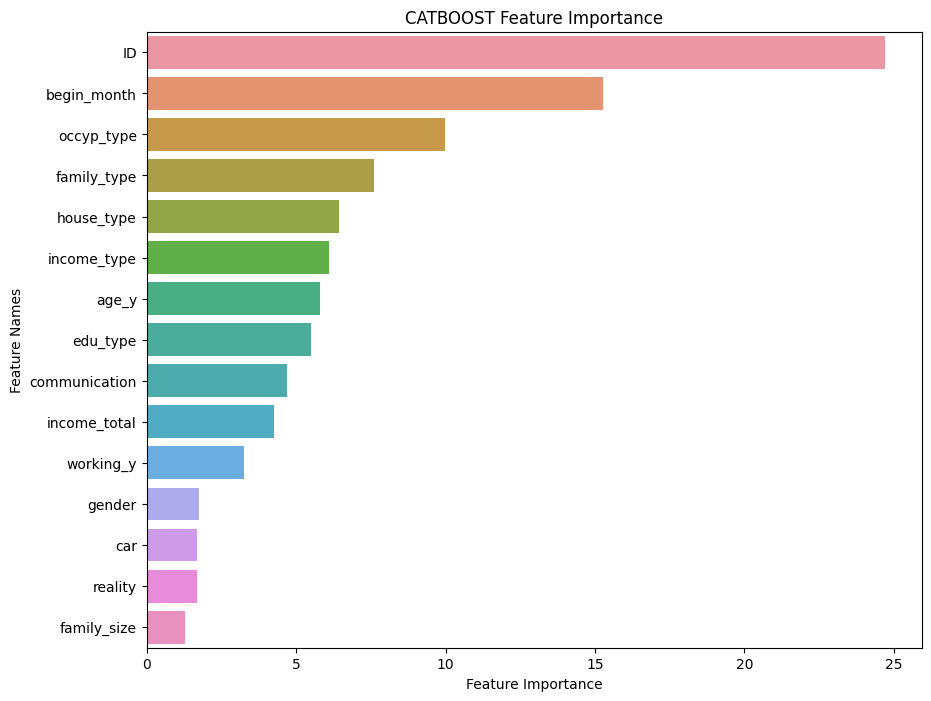

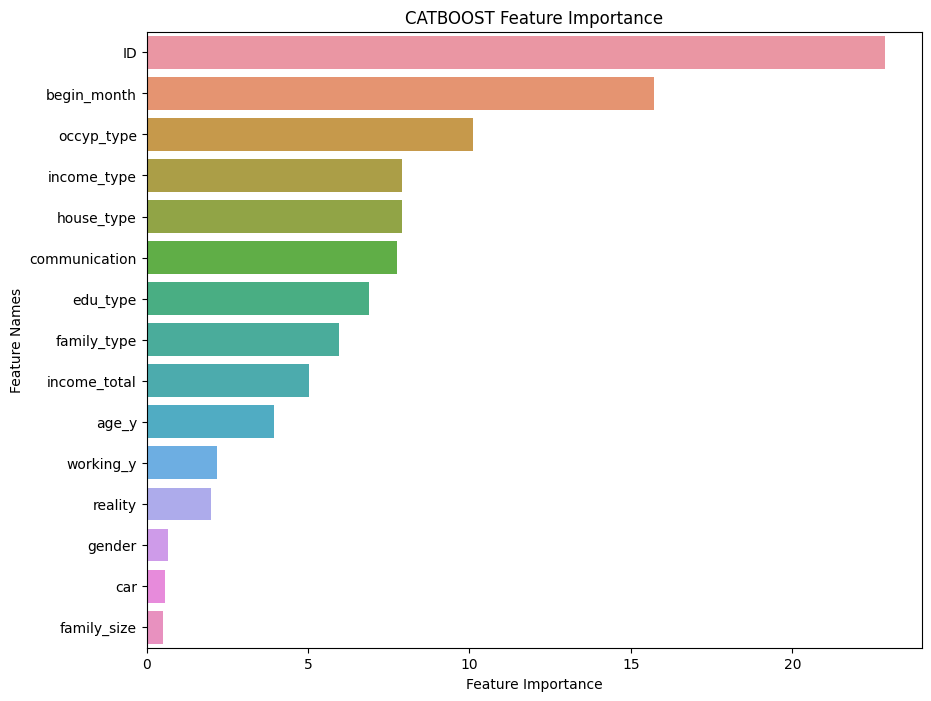

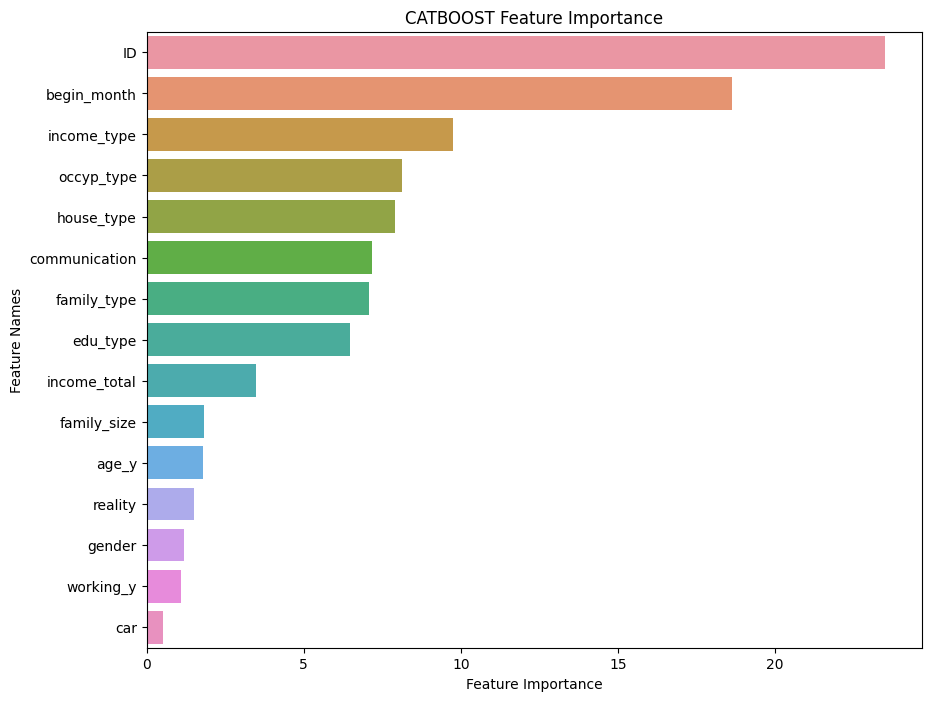

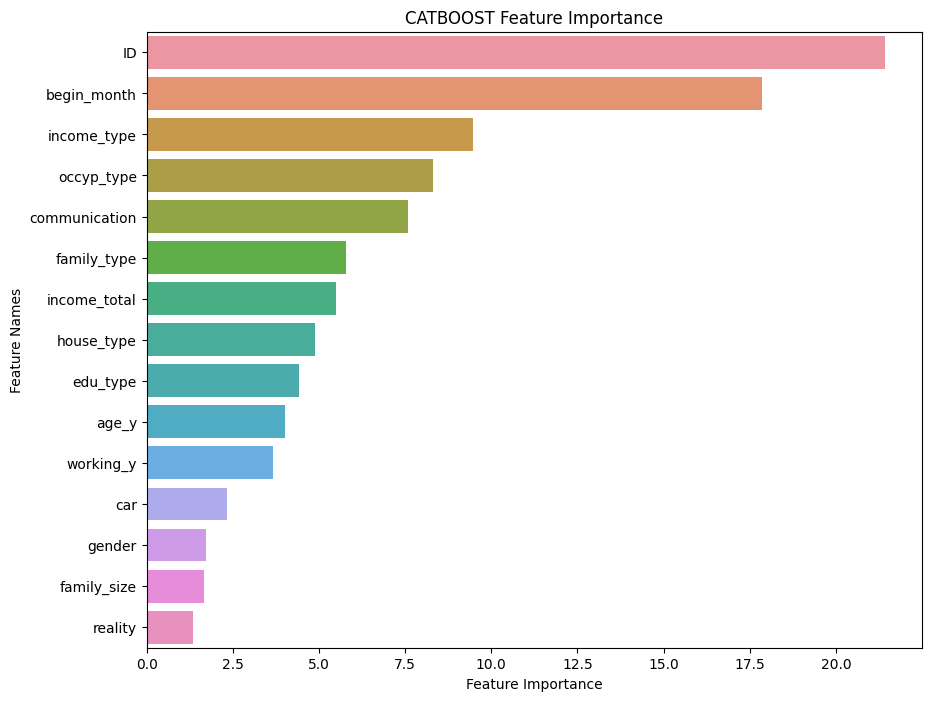

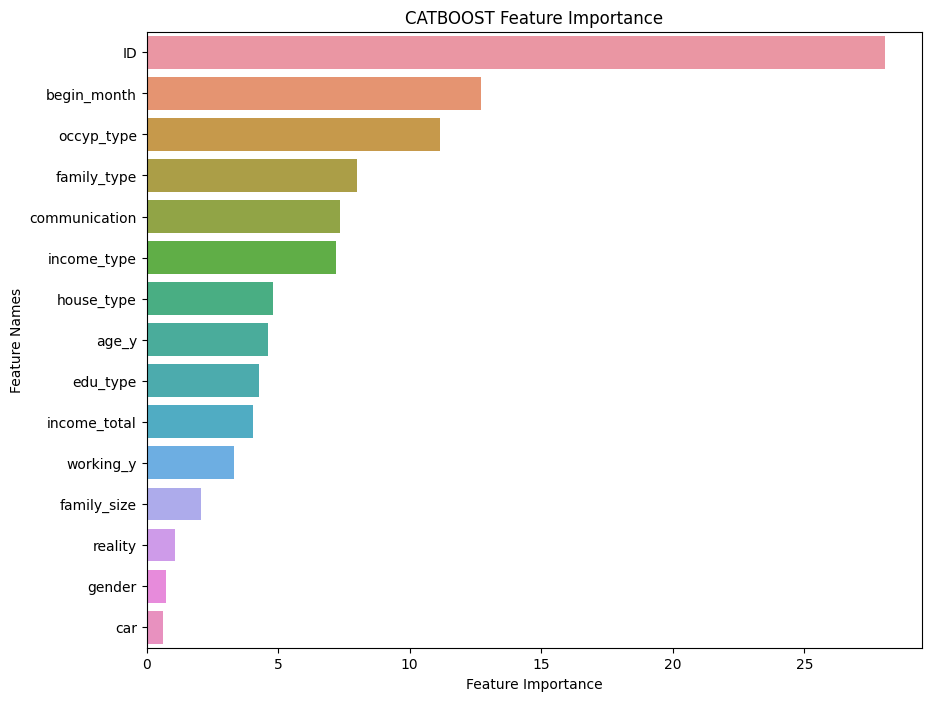

In [99]:
# cat_models의 5개 모델에 대한 feature importance plot
# 보면 기본적으로 ID, begin_month, occyp_type의 중요도가 높음
for fold in range(5):
    plot_feature_importance(cat_models[fold].get_feature_importance(), test.columns,'CATBOOST')

In [106]:
# submission
submission = pd.read_csv('sample_submission.csv')

submission.iloc[:, 1:] = 0
for fold in range(5):
  submission.iloc[:, 1:] += cat_models[fold].predict_proba(test)/5

submission.to_csv("submission.csv", index=False)